# Deep Learning, Neural Networks and Embeddings


# What is an _embedding_? 

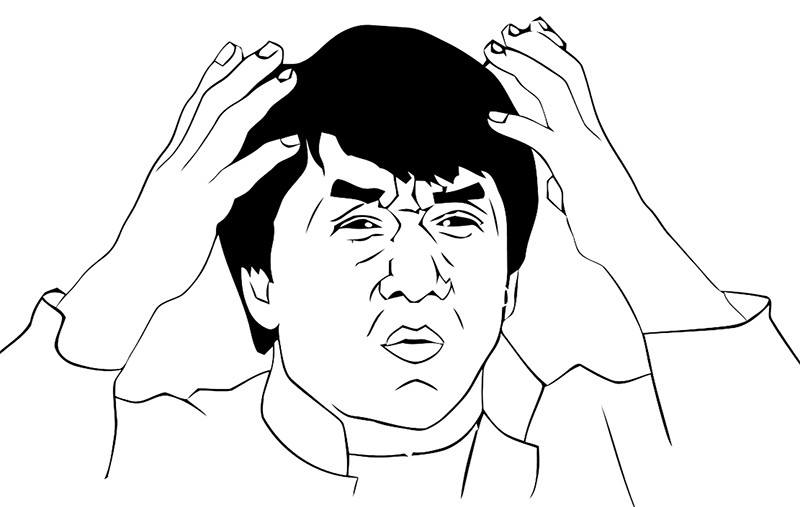
    
     
     
   * An embedding is a mapping of a discrete-categorical-variable to a vector of continuous numbers. 
   * In the context of neural networks, embeddings are useful because they can reduce the dimensionality of categorical variables and meaningfully represent categories in the transfored vector space. 

### 3 primary purposes of Neural Network Embeddings: 

1. Finding k-nearest neighbors in the embedding space (these can be used to make recommendations based on the users interest or cluster categories)
2. Input to a machine learning model for a supervised learning task 
3. Visualization of concepts and relations between categories


_This means in terms of the maintenence project, using __neural network embeddings__ we can take all __40,000 maintenence requests__ and represent each one using only __50 numbers in vectors__._ 

_Moreover, because embeddings are learned, maintenence requests that are __more similar__ are closer to one another in the embedding space._

Cool right?!

To create entity embeddings, we need to build an embedding neural network and train it on a _supervised ML task_ that will result in similar maintenence requests having closer representations in the embedding space. 

The parameters of the neural network (the __weights__) are the embeddings, so during training, these numbers are adjusted to __minimize the loss on the prediction__ problem. 


Once we have these embeddings, we can find the _most similar maintenence requests_ to a given maintenence category by computing the __distance__ between the embedded vector for that category and all the other MR embeddings.

### To compute the distance between to vectors: 

- We can use [__cosine distance__](https://en.wikipedia.org/wiki/Cosine_similarity) which _measures the angle between two vectors as a measure of similarity_.

    - A function to find most similar entities would take in either a maintence request category or a MR text/comment, a set of embeddings and returns the _n most similar items_ to the query. 
    - We can do this by computing the [dot product](https://en.wikipedia.org/wiki/Dot_product) between the query and embeddings (assuming we normalize the embeddings). 

   - Once we have the dot products, we can sort the results to find the closest entities in the embedding space. With cosine similarity, higher numbers indicate entities that are closer together, with -1 the furthest apart and +1 closest together.

- We could also use the Euclidean distance which in contrast does depend on the magnitude of the vector (if time allows we will experiment to see which metric measures similarity better).  



The following steps to complete this are: 

1. Load the data and clean it some more
2. Prepare data for the supervised machine learning task (i.e. tokenize ect) 
3. Build the entity embedding neural network
4. Train the neural network on the prediction task 
5. Extract embeddings and find most similar maintenence requests and categories
5. Visualize the embeddings using dimention reduction techniques


# Neural Network embeddings

Neural Network embeddings have proven to be very powerful concepts both for modeling language and for representing categorical variables. For example, the [Word2Vec word embeddings](https://www.tensorflow.org/tutorials/representation/word2vec)
map a word to a vector based on training a neural network on millions of words. These embeddings can be used in any supervised model because they are just numerical representations of categorical variables. Much as we one-hot-encode categorical variables to use them in a random forest for a supervised task, we can also use entity embeddings to include categorical variables in a model. The embeddings are also useful because we can find entities that are close to one another in embedding space which might - as in a book recommendation system - allow us to find the most similar categories among tens of thousands of choices.

We can also use the __Entity Embeddings to visualize words or categorical variables__, such as creating a map of all maintences requests. The entity embeddings typically are still high-dimensional - we'll use 50 numbers for each entity - so we need to use a _dimension reduction technique_ such as
- [TSNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) (t-distributed stochastic neighbor embedding) 
or
- UMAP 

to __visualize the embeddings in lower dimensions__.

# Inspiration 

An application custom-built for this purpose: [projector.tensorflow.org](https://projector.tensorflow.org/)


In [1]:
#Imports the libraries and read the data files

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import os, sys

import gensim
from gensim.models import Doc2Vec
from gensim.models import Word2Vec
from gensim import utils
from gensim.models import word2vec, keyedvectors
from gensim.test.utils import datapath, get_tmpfile, temporary_file, common_texts as sentences

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from string import punctuation
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.decomposition import PCA

import pylab as pl
import matplotlib.pyplot as plt

import timeit
start = timeit.default_timer()

## 1. Load the data and clean it some more

In [2]:
file = 'cleaned_workorders_nov15.csv'
file_df = pd.read_csv('cleaned_workorders_nov15.csv', nrows=50000)
file_df.head()

,Unnamed: 0,HybridID,id,category_id,title,text,Author,ChoiceString,OtherFlag,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,0,735,35,7,NaN,Walk with a dog. . walk with my dog Can I or...,LL,Other,1.0,NaN,NaN,NaN,NaN,NaN
1,1,749,49,7,NaN,. Repair Kitchen Window Window falls out whe...,LL,Other,1.0,NaN,NaN,NaN,NaN,NaN
2,2,750,50,7,NaN,. Fire Alarm Light bulb & plastic cover The ...,LL,Other,1.0,NaN,NaN,NaN,NaN,NaN
3,3,751,51,7,NaN,. Main Entrance Door lock needs to be replace...,LL,Other,1.0,NaN,NaN,NaN,NaN,NaN
4,4,752,52,7,NaN,. Window Screens For Front Bedroom and Midd...,LL,Other,1.0,NaN,NaN,NaN,NaN,NaN


## 2. Prepare the data for the supervised machine learning task 

In [3]:
#Data cleaning
def text_cleaning(text):
    text_content = []
    if type(text) is str:
        text = text.lower()
        text_content = text.split()    
    # clean and tokenize document string
    word_list = []
    for i in text_content:
        x = 0
        if (('http' not in i) and ('@' not in i) and ('<.*?>' not in i) and i.isalnum() and (not i in stop_words)):
            word_list += [i]

    return word_list 

#Data Pre-processing
def preprocessing(text):    
    # remove numbers
    number_tokens = [re.sub(r'[\d]', ' ', i) for i in text]
    number_tokens = ' '.join(number_tokens).split()
     # stem tokens
    stemmed_tokens = [p_stemmer.stem(i) for i in number_tokens]
    # remove empty
    length_tokens = [i for i in stemmed_tokens if len(i) > 1]
    return length_tokens

In [4]:
LabeledSentence1 = gensim.models.doc2vec.TaggedDocument
all_content = []
texts = []
j=0
k=0
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
p_stemmer = PorterStemmer()
for t in file_df.text:           
    #Data cleaning
    clean_content = text_cleaning(t)
    
    #Pre-processing
    preprocessed_text = preprocessing(clean_content)
    
    # add tokens to list
    if preprocessed_text:
        all_content.append(LabeledSentence1(preprocessed_text,[j]))
        j+=1
        
    k+=1

print("Number of text processed: ", k)
print("Number of non-empty text vectors: ", j)

Number of text processed:  50000
Number of non-empty text vectors:  40656


In [5]:
print(all_content[0:10])

[TaggedDocument(words=['walk', 'walk', 'dog', 'order', 'citi', 'saturday', 'realli', 'need', 'someon', 'walk'], tags=[0]), TaggedDocument(words=['repair', 'kitchen', 'window', 'window', 'fall', 'unlock'], tags=[1]), TaggedDocument(words=['fire', 'alarm', 'light', 'bulb', 'plastic', 'cover', 'fire', 'alarm', 'light', 'bulb', 'light', 'bulb', 'cover', 'broken', 'previou', 'tenant', 'move'], tags=[2]), TaggedDocument(words=['main', 'entranc', 'door', 'lock', 'need', 'replac', 'main', 'entranc', 'door', 'lock', 'need', 'work'], tags=[3]), TaggedDocument(words=['window', 'screen', 'front', 'bedroom', 'middl', 'bedroom'], tags=[4]), TaggedDocument(words=['dine', 'room', 'light', 'batteri', 'dine', 'room', 'light', 'tenant', 'alreadi', 'check', 'breaker', 'light', 'bulb'], tags=[5]), TaggedDocument(words=['run', 'toilet', 'apart', 'downstair', 'toilet', 'non', 'stop'], tags=[6]), TaggedDocument(words=['repair', 'downstair', 'unit', 'water', 'damag', 'subject', 'unit', 'water', 'leak', 'caus',

## Supervised Machine Learning Task

Now that we have the clean data, we'll move on to the second step: developing a supervised machine learning task to train an embedding neural network. 

Our supervised learning task could be defined as:  _given a maintenence request category and maintenence request text, identify if the category is in the MR text_.  


## Build a training set 
    3. Build the entity embedding neural network
    4. Train the neural network on the prediction task 

In order for any machine learning model to learn, it needs a training set. 

We are going to treat this as a supervised learning problem: 

    given a pair (MR category, MR text), we want the neural network to learn to predict whether this is a legitimate pair - present in the data - or not.

To create a training set, for each MR category, we'll iterate through the comments on the MR category and record the MR category and each coment as a tuple. The final pairs list will consist of tuples of every (MR category, comment) pairing on all of the maintence request data.

## Create a model using Gensims Doc2Vec 
* _all_conent_: list of split sentences 

* _vector size_: vector size with 2000 words ( this is the dimensionality of the embedding vector)
* _window_: the number of context words you are looking at
* _min_count_: tells the model to ignore words with total count less than this number.
.
* _workers_: the number of threads being used
* _dm_:
* alpha
* min_alpha 

In [6]:
d2v_model = Doc2Vec(all_content, vector_size = 2000, window = 10, min_count = 500, workers=7, dm = 1, 
                alpha=0.025, min_alpha=0.001)

### Gensim makes it easy to train a model in one line

In [7]:
d2v_model.train(all_content, total_examples=d2v_model.corpus_count, epochs=10, start_alpha=0.002, end_alpha=-0.016)

In [8]:
d2v_model.wv.vocab['leak'].count

4044

In [9]:
print( "How many Docment vectors are there?", d2v_model.docvecs.count)

How many Docment vectors are there? 40656


## Save the model 
    Will be important to save the model in the right format but we'll get to that later 

In [10]:
# fs, temp_path = mkstemp("gensim_temp.tsv")  # creates a temp file
# model = d2v_model.save_word2vec_format(temp_path)  # save the model
# tmpf = get_tmpfile('gensim_word2vec.tsv')
# model = word2vec.Word2Vec(sentences, min_count=1)
# model.init_sims()
# testvocab = get_tmpfile('gensim_word2vec.vocab')
# model.wv.save_word2vec_format(tmpf, testvocab, binary=True)
# binary_model_with_vocab_kv = keyedvectors.KeyedVectors.load_word2vec_format(tmpf, testvocab, binary=True)
# binary_model_with_vocab_kv.save(tmpf)

In [11]:
from tempfile import mkstemp
fs, d2v_temp_path = mkstemp("gensim_temp")  # creates a temp file
d2v_model.save(d2v_temp_path)  # save the model

### Explore the data using gensims text similarity utils 

In [12]:
# shows the similar docs with id = 99
print (d2v_model.wv.most_similar(["sink"],topn=5))

[('faucet', 0.9305422306060791), ('kitchen', 0.909125804901123), ('drain', 0.8923043608665466), ('tub', 0.8829955458641052), ('pipe', 0.8493763208389282)]


/Users/sarahgibbons/anaconda3/lib/python3.7/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


### Apply k-means clustering on the model

In [13]:
kmeans_model = KMeans(n_clusters=4, init='k-means++', max_iter=100)  
X = kmeans_model.fit(d2v_model.docvecs.vectors_docs)
labels=kmeans_model.labels_.tolist()

In [14]:
l = kmeans_model.fit_predict(d2v_model.docvecs.vectors_docs)
pca = PCA(n_components=2).fit(d2v_model.docvecs.vectors_docs)
datapoint = pca.transform(d2v_model.docvecs.vectors_docs)

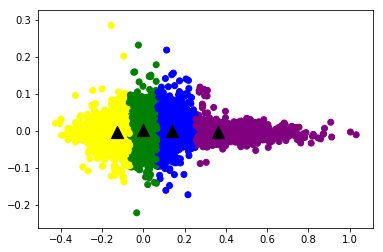

In [15]:
plt.figure
label1 = ["#FFFF00", "#008000", "#0000FF", "#800080"]
color = [label1[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)

centroids = kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

In [16]:
stop = timeit.default_timer()
execution_time = stop - start

print(execution_time) #It returns time in sec

89.3994896080003


In [17]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, value

output_notebook()

Loading BokehJS ...

In [1]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, value

output_notebook()
# add our DataFrame as a ColumnDataSource for Bokeh
plot_data = ColumnDataSource(d2v_model.docvecs)

# create the plot and configure the
# title, dimensions, and tools
tsne_plot = figure(title=u't-SNE Word Embeddings',
                   plot_width = 800,
                   plot_height = 800,
                   tools= (u'pan, wheel_zoom, box_zoom,'
                           u'box_select, resize, reset'),
                   active_scroll=u'wheel_zoom')

# add a hover tool to display words on roll-over
tsne_plot.add_tools( HoverTool(tooltips = u'@word') )

# draw the words as circles on the plot
tsne_plot.circle(u'x_coord', u'y_coord', source=plot_data,
                 color=u'blue', line_alpha=0.2, fill_alpha=0.1,
                 size=10, hover_line_color=u'black')

# configure visual elements of the plot
tsne_plot.title.text_font_size = value(u'16pt')
tsne_plot.xaxis.visible = False
tsne_plot.yaxis.visible = False
tsne_plot.grid.grid_line_color = None
tsne_plot.outline_line_color = None

# engage!
show(tsne_plot);

Loading BokehJS ...

NameError: name 'd2v_model' is not defined